# ML Project: Classification 

## Predict what feature has more influence over income 

- Education vs Salary
- Sex vs Salary 

$50K/yr based on census data

Authors:
`Andrea Murphy` and `Josh Quigley`

## Setup

In [1]:
%matplotlib inline
import random

import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
from time import time
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [3]:
import pylab as plot
params = { 
    "axes.labelsize": "large",
    "xtick.labelsize" : "x-large",
    "legend.fontsize": 20,
    "figure.dpi": 150,
    "figure.figsize" : [25, 7]
}
plot.rcParams.update(params)

In [4]:
data = pd.read_csv('data/adult.data.txt')
test_data = pd.read_csv('data/adult.test.txt') 

data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
                           "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [5]:
# This dataset has 32,559 records
data.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


In [6]:
type(data.index)

pandas.core.indexes.range.RangeIndex

In [7]:
# Check to see if there are nulls
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [8]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary             int64
dtype: object

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
age               32560 non-null int64
workclass         32560 non-null object
fnlwgt            32560 non-null int64
education         32560 non-null object
education-num     32560 non-null int64
marital-status    32560 non-null object
occupation        32560 non-null object
relationship      32560 non-null object
race              32560 non-null object
sex               32560 non-null object
capital-gain      32560 non-null int64
capital-loss      32560 non-null int64
hours-per-week    32560 non-null int64
native-country    32560 non-null object
salary            32560 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


# Education (and Age) vs Salary 

In [10]:
# drop columns won't be useful in analysis and prediction
data_education = data.drop(['fnlwgt', 'hours-per-week', 'native-country', 'sex', 'race', 'education', 'relationship', 'occupation', 'marital-status', 'workclass', 'capital-gain', 'capital-loss'], axis=1)

In [11]:
# sample 10000 random entries to train
data_education = data_education.sample(n=10000)

In [12]:
#Let's see what's left
data_education.head()

,age,education-num,salary
22944,54,6,0
551,72,7,0
1594,33,9,1
15668,31,13,1
30186,33,9,0


In [13]:
data_education.shape

(10000, 3)

In [14]:
# The 3 largest categories are Highschool Graduates (education-num 9),
# Some College Education (education-num 10), and Bachelors Degrees (education-num 13). 

data_education["education-num"].value_counts()

9     3182
10    2304
13    1591
14     492
11     434
7      357
12     340
6      321
15     187
4      180
5      171
16     140
8      122
3      105
2       58
1       16
Name: education-num, dtype: int64

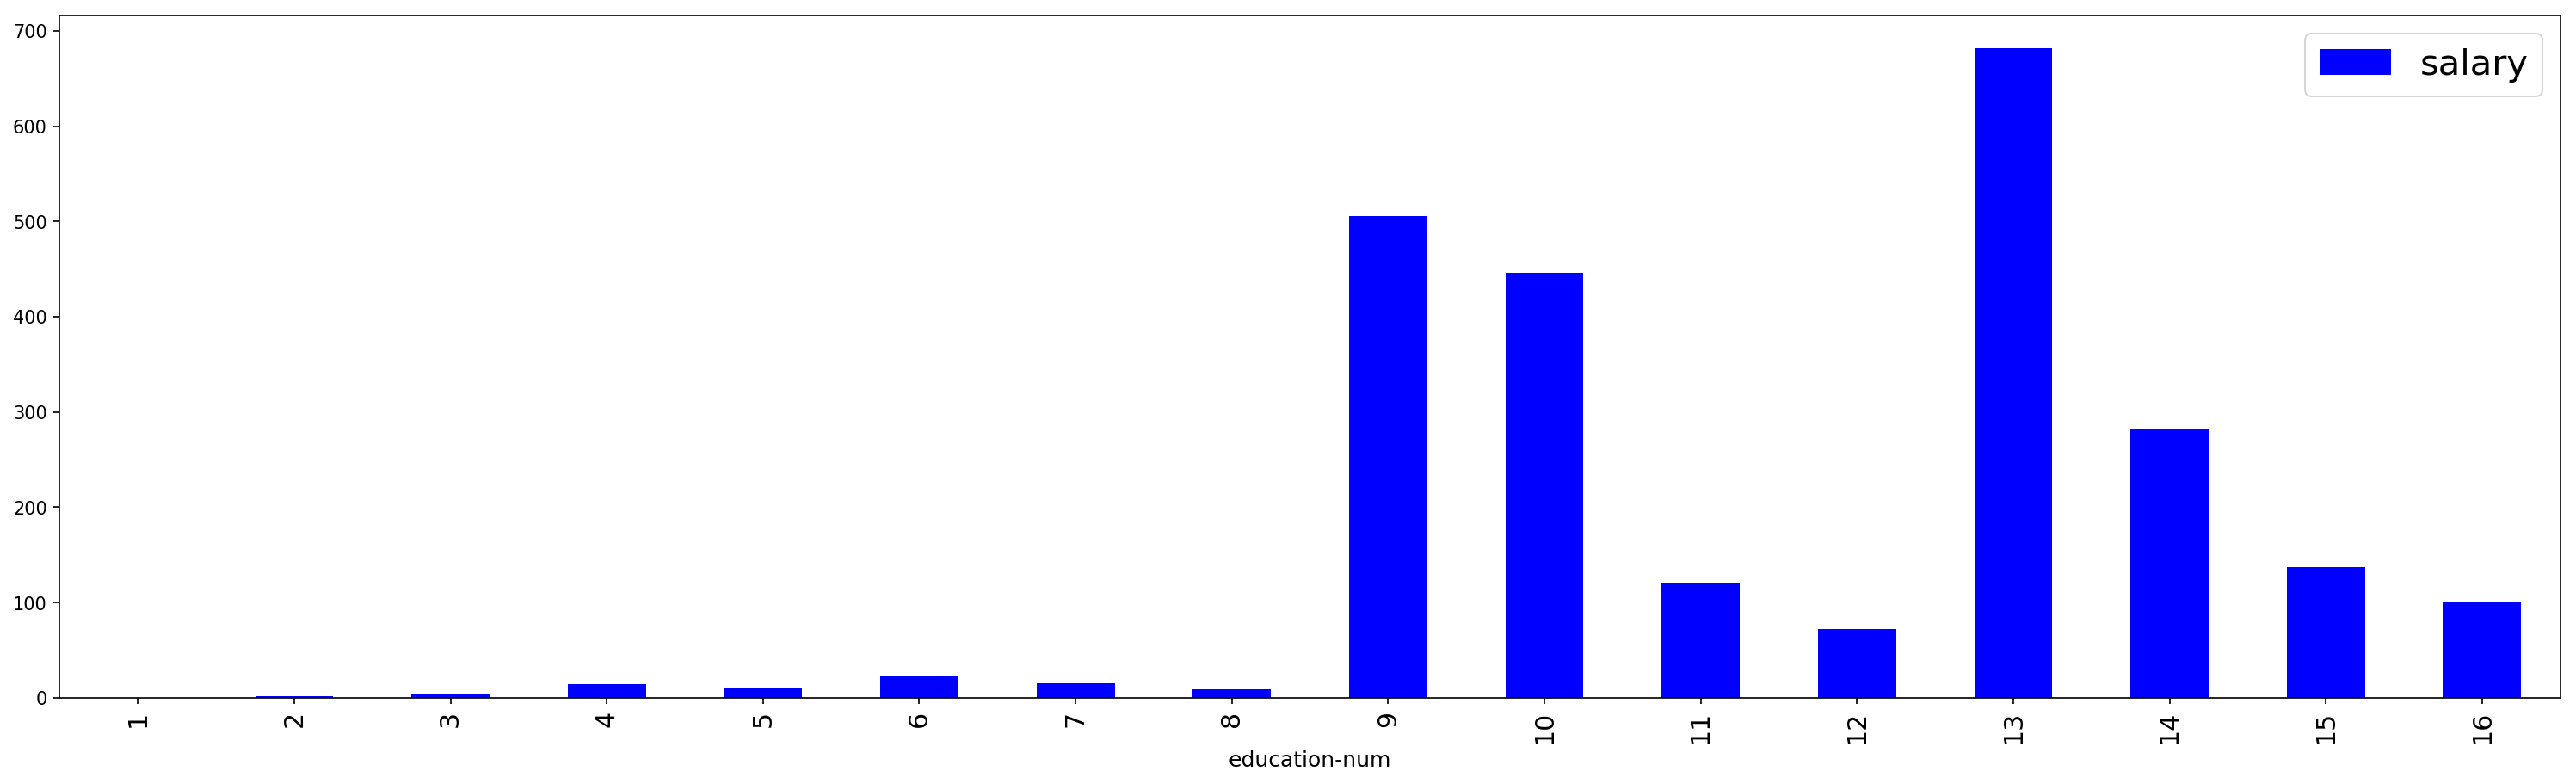

In [15]:
#Bar graph exploring which education groups are making $50,000 or more.

data_education.groupby('education-num').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [16]:
#X Train and y-train have 70000 records of education-num and age and y-train has 70000 records of salary.
#X Test has 3000 withheld records on education-num and age and y-test has 3000 records of salary.

X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

## Decision Tree

In [17]:
# Now we train using a Decision Tree Classifier - A model represented as a sequence of branching statements
# random_state reproduces the same sequence of random numbers for comparing identical training sessions.
# max_depth indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data.
# min_samples_leaf is the minimum number of samples required to be at a leaf node

tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=100)

In [18]:
# We will time how long it takes to fit the model

start_time = time()
tree_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.00s


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

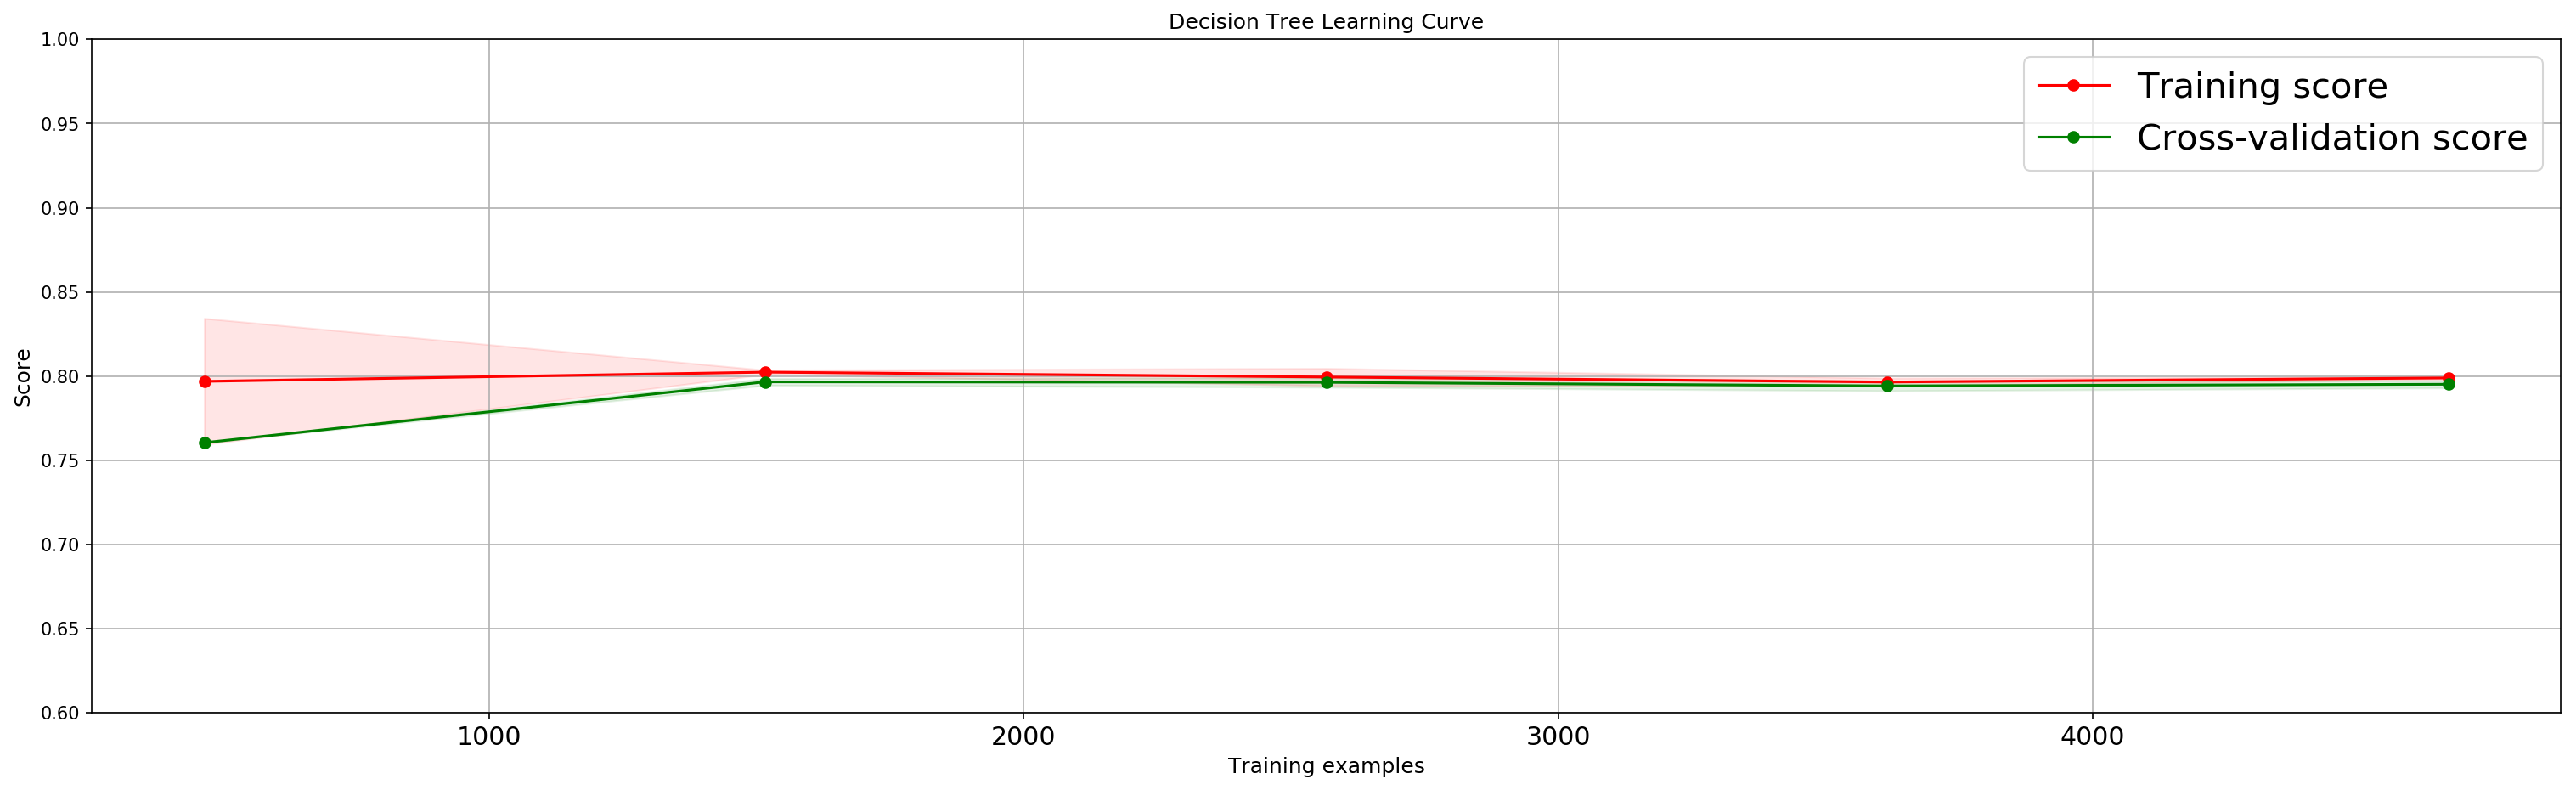

In [19]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_train, y_train, ylim=(0.6, 1.0), cv=3)   

In [20]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.79305913, 0.79425632, 0.79811402])

In [21]:
y_train_pred_tree_clf = cross_val_predict(tree_clf, X_train, y_train, cv=3)

In [22]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_tree_clf)

array([[4969,  354],
       [1080,  597]])

In [23]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="precision")

array([0.61949686, 0.62700965, 0.63664596])

In [24]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="recall")

array([0.35241503, 0.34883721, 0.3667263 ])

## Test Data

In [25]:
y_pred_tree_clf = tree_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

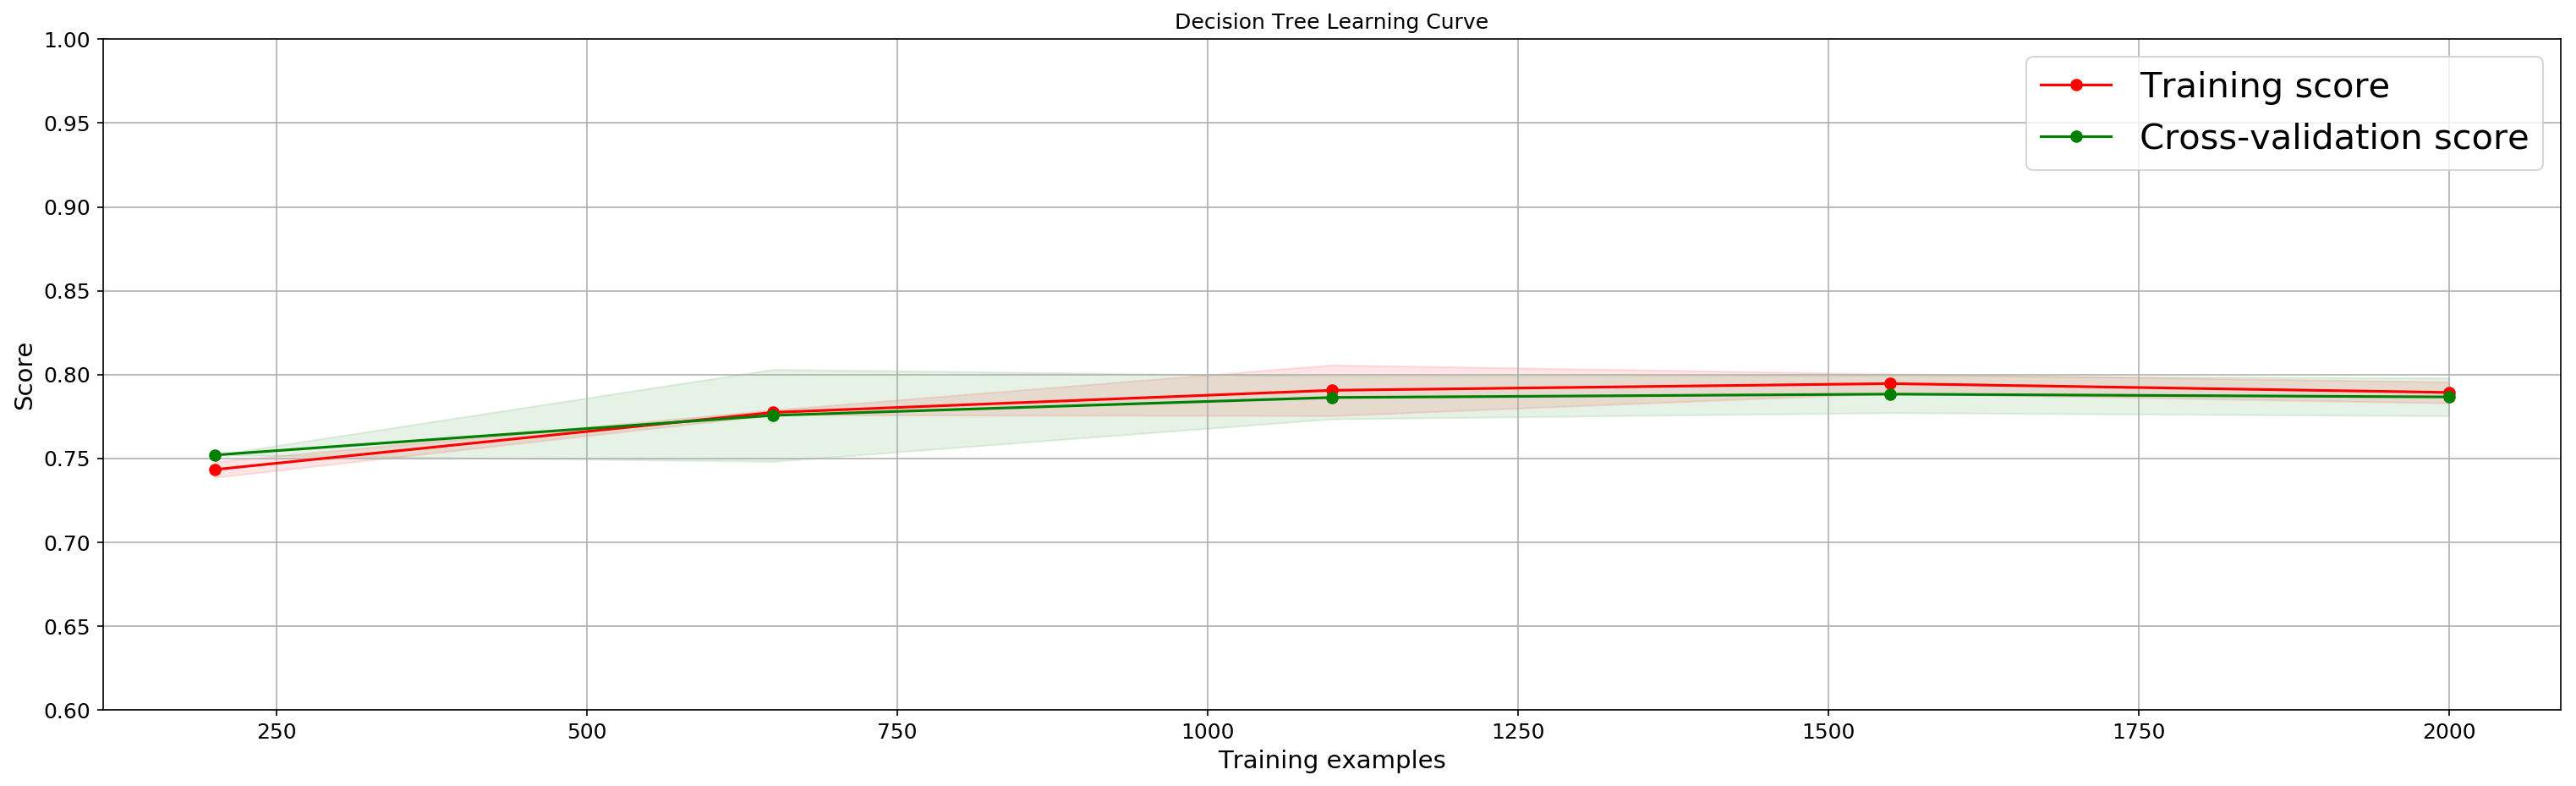

In [26]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_test, y_test, ylim=(0.6, 1.0), cv=3)   

In [27]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(tree_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.775, 0.802, 0.783])

In [28]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_tree_clf)

array([[2139,  117],
       [ 548,  196]])

In [29]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_tree_clf)

0.6261980830670927

In [30]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_tree_clf)

0.26344086021505375

## Support Vector Machine

In [31]:
# Now we train using a Support Vector Machine - a very powerful and versatile Machine Learning model, 
# capable of performing linear or nonlinear classification
# random_state reproduces the same sequence of random numbers for comparing identical training sessions.

svm_clf = SVC(random_state=42)

In [32]:
# We time how long it takes to fit the model

start_time = time()
svm_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Time elapsed: 0.81s


In [33]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.78920308, 0.79082726, 0.79382769])

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

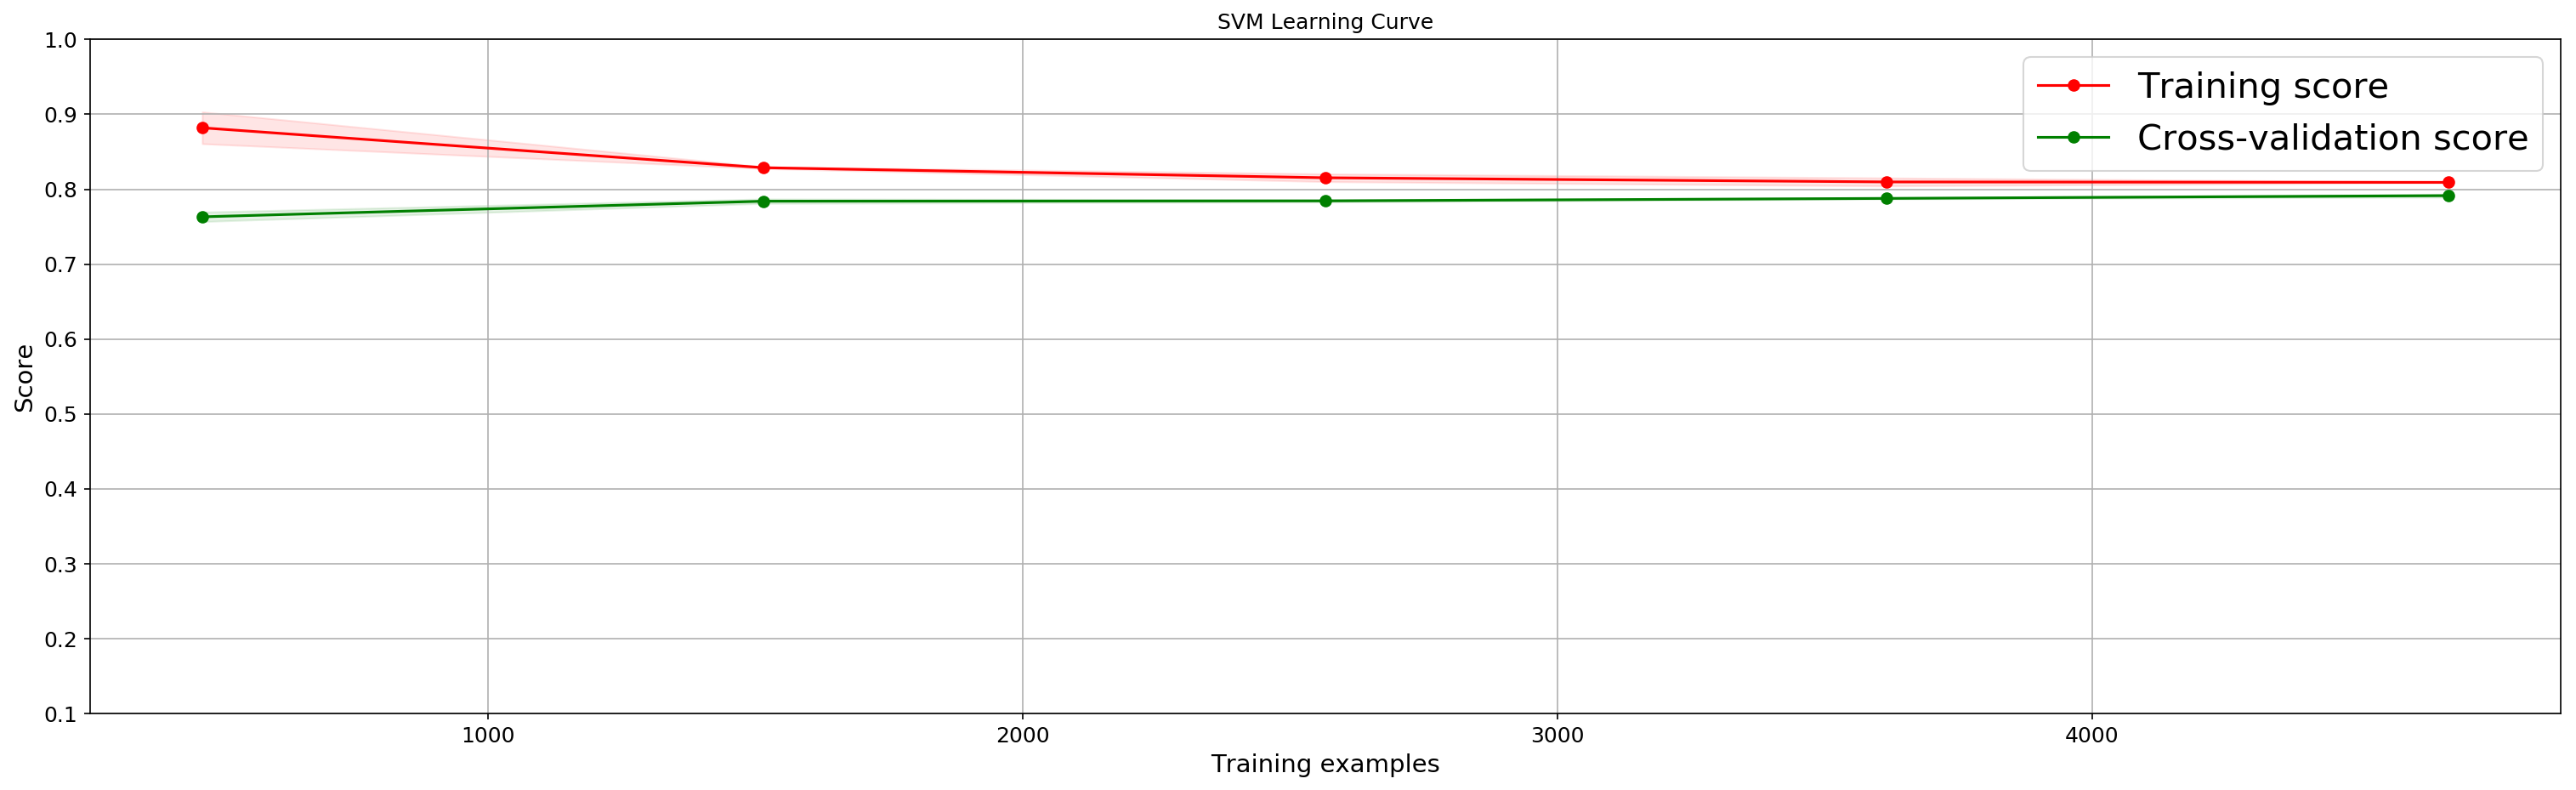

In [34]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_train, y_train, ylim=(0.1, 1.0), cv=3)    

In [35]:
y_train_pred_svm_clf = cross_val_predict(svm_clf, X_train, y_train, cv=3)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_svm_clf)

array([[4976,  347],
       [1114,  563]])

In [37]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="precision")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.61754386, 0.61128527, 0.62745098])

In [38]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="recall")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.31484794, 0.34883721, 0.34347048])

## Test Data

In [39]:
y_pred_svm_clf = svm_clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

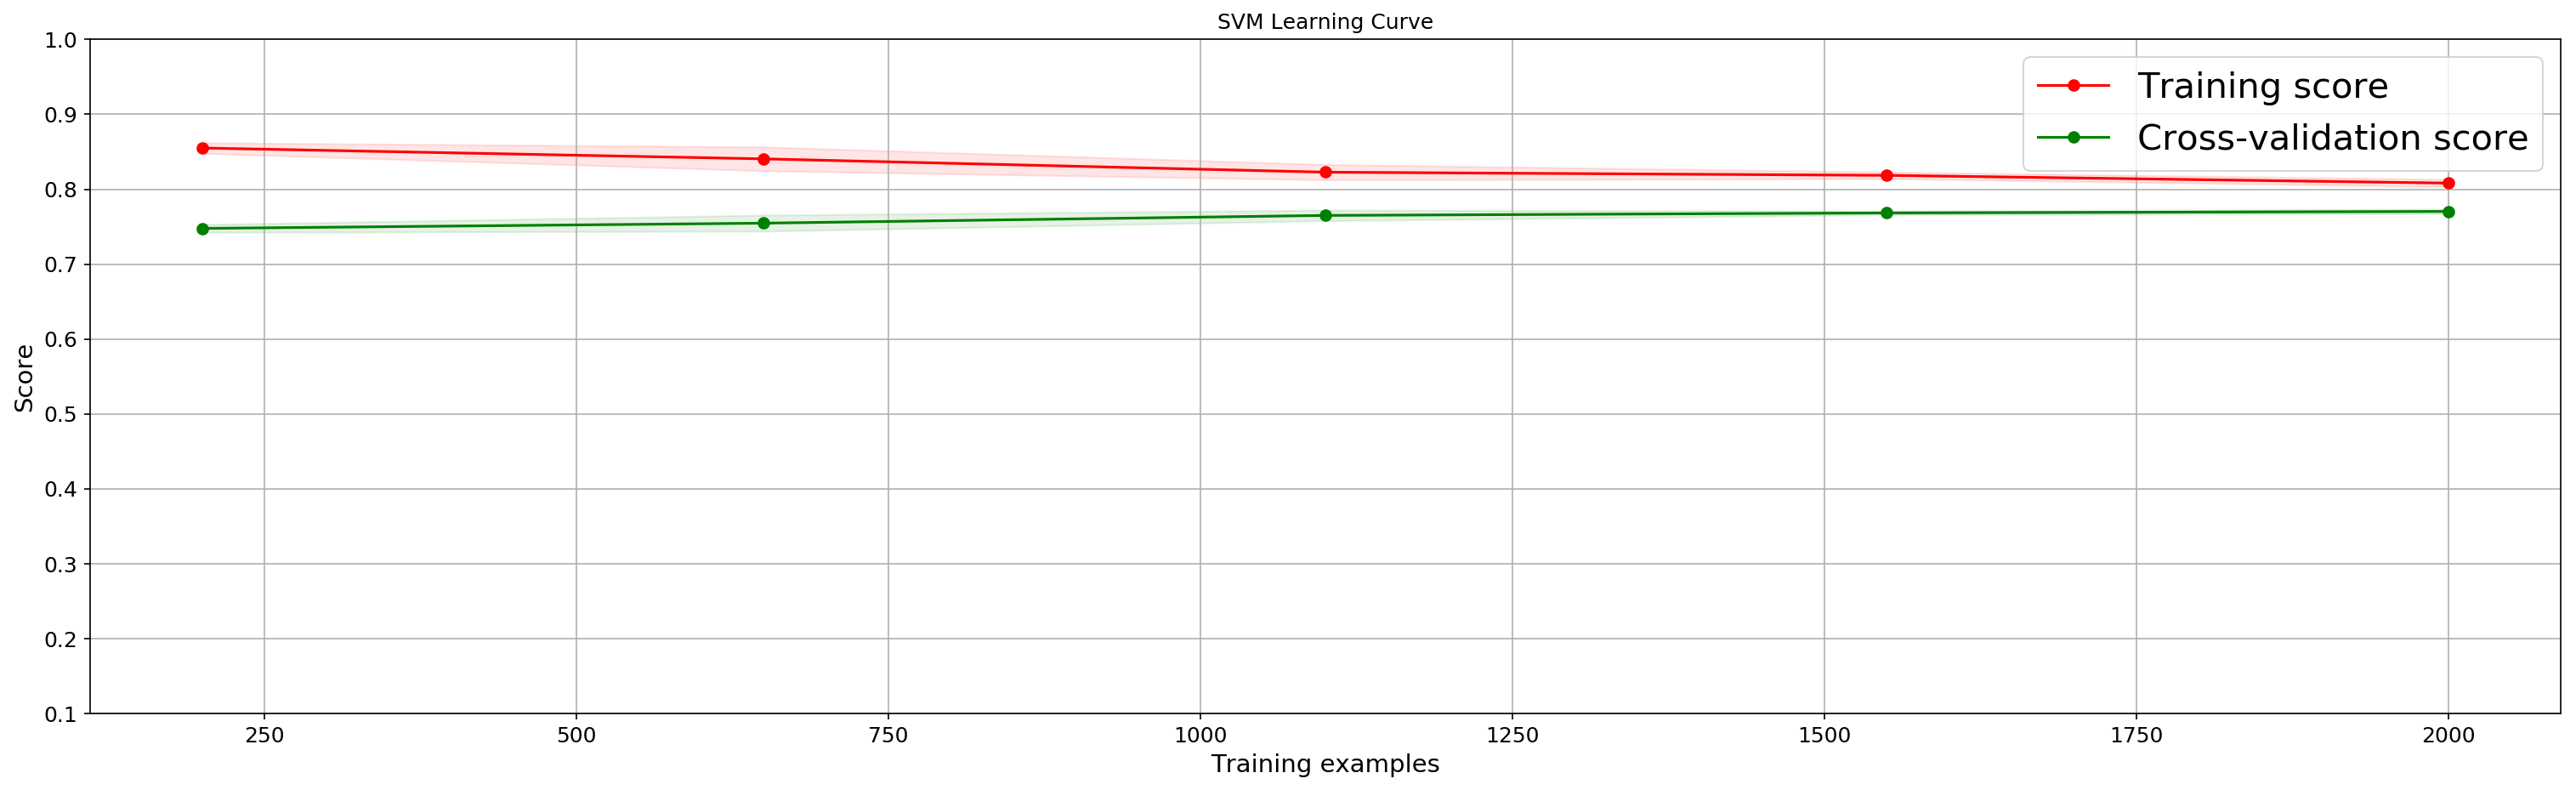

In [40]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_test, y_test, ylim=(0.1, 1.0), cv=3)   

In [41]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(svm_clf, X_test, y_test, cv=3, scoring="accuracy")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.766, 0.773, 0.772])

In [42]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_svm_clf)

array([[2101,  155],
       [ 491,  253]])

In [43]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_svm_clf)

0.6200980392156863

In [44]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_svm_clf)

0.3400537634408602

## Logistic Regression Classifier

In [45]:
# Now we train using a Logistic Regression Classifier - A model that generates a probability for each 
# possible discrete label value in classification problems by applying a sigmoid function to a linear prediction.
# random_state reproduces the same sequence of random numbers for comparing identical training sessions.
# solver liblinear is the standard logistic regression solver, good for small linear datasets.

logit_clf = LogisticRegression(solver = 'liblinear', random_state=42)

In [46]:
# We time how long it takes to fit the model

start_time = time()
logit_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.02s


In [47]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.78748929, 0.7861123 , 0.7886841 ])

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

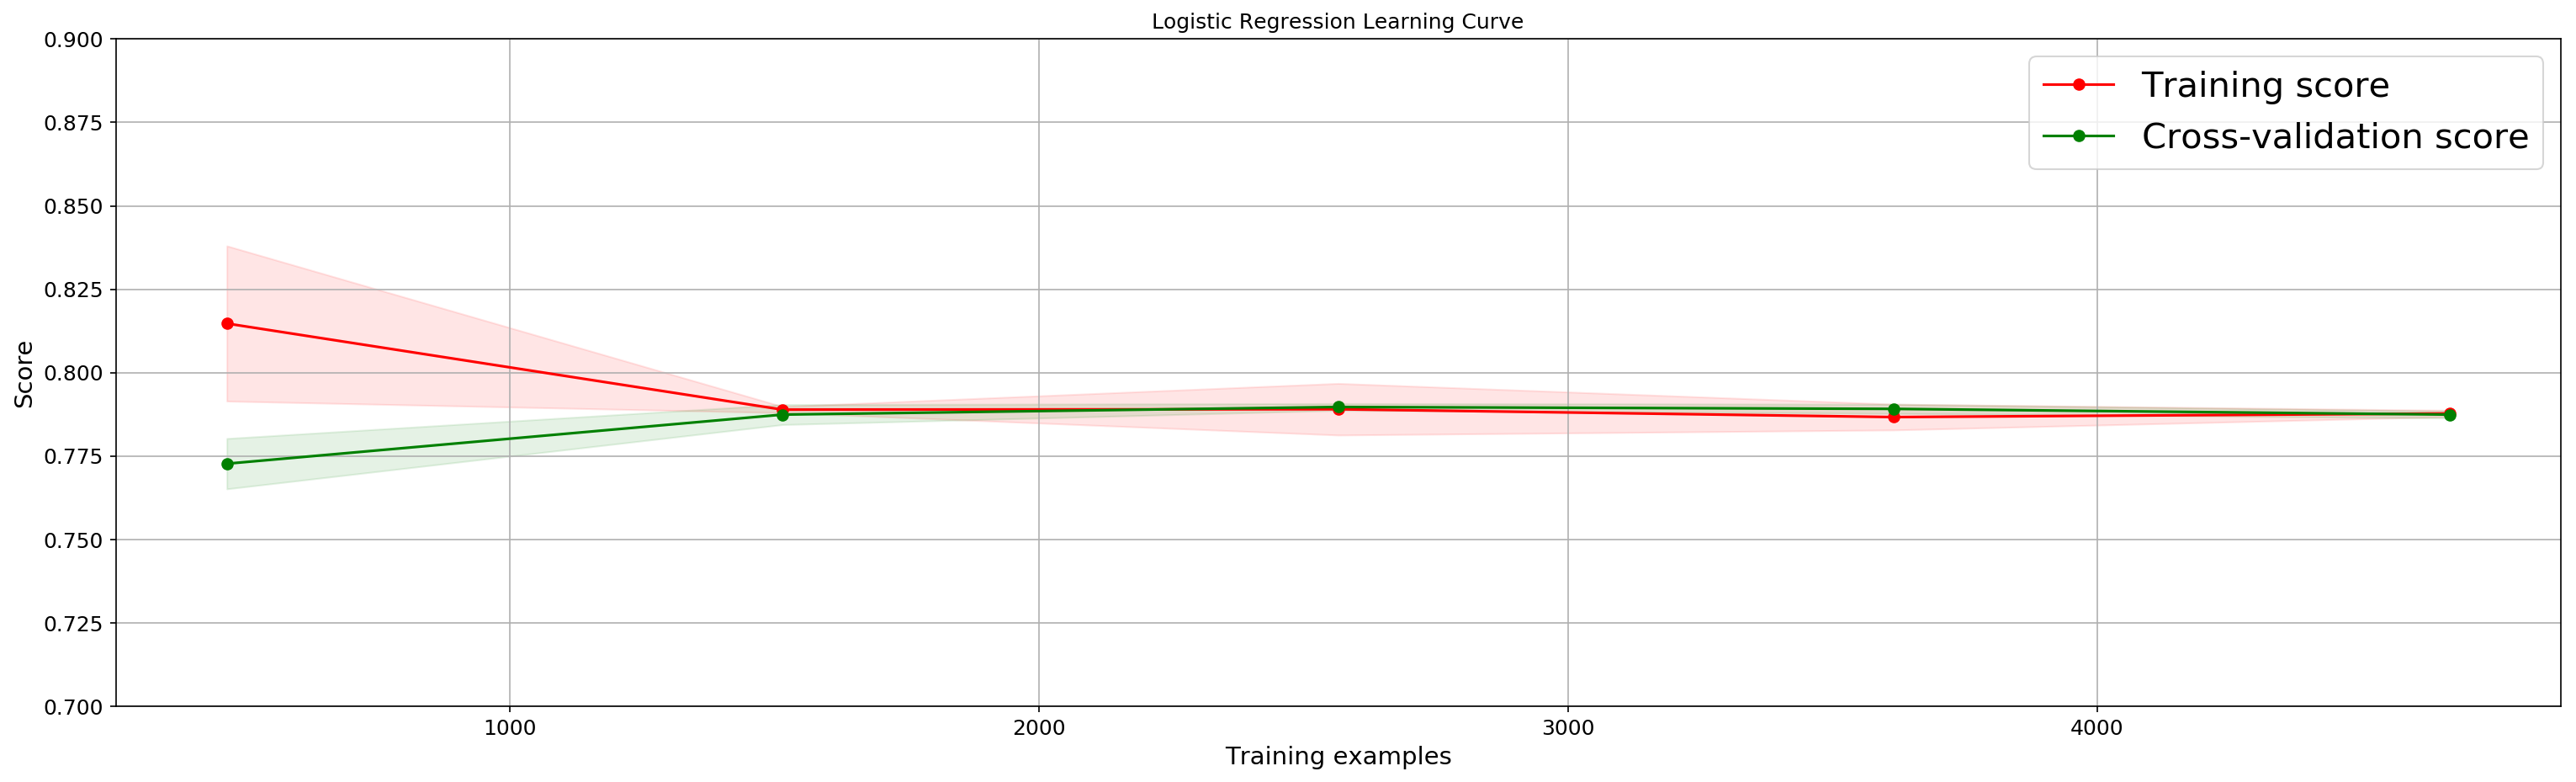

In [48]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_train, y_train, ylim=(0.7, 0.9), cv=3)   

In [49]:
y_train_pred_logit_clf = cross_val_predict(logit_clf, X_train, y_train, cv=3)

In [50]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_logit_clf)

array([[5049,  274],
       [1214,  463]])

In [51]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="precision")

array([0.64651163, 0.61029412, 0.632     ])

In [52]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="recall")

array([0.24865832, 0.29695886, 0.28264758])

## Test Data

In [53]:
y_pred_logit_clf = logit_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

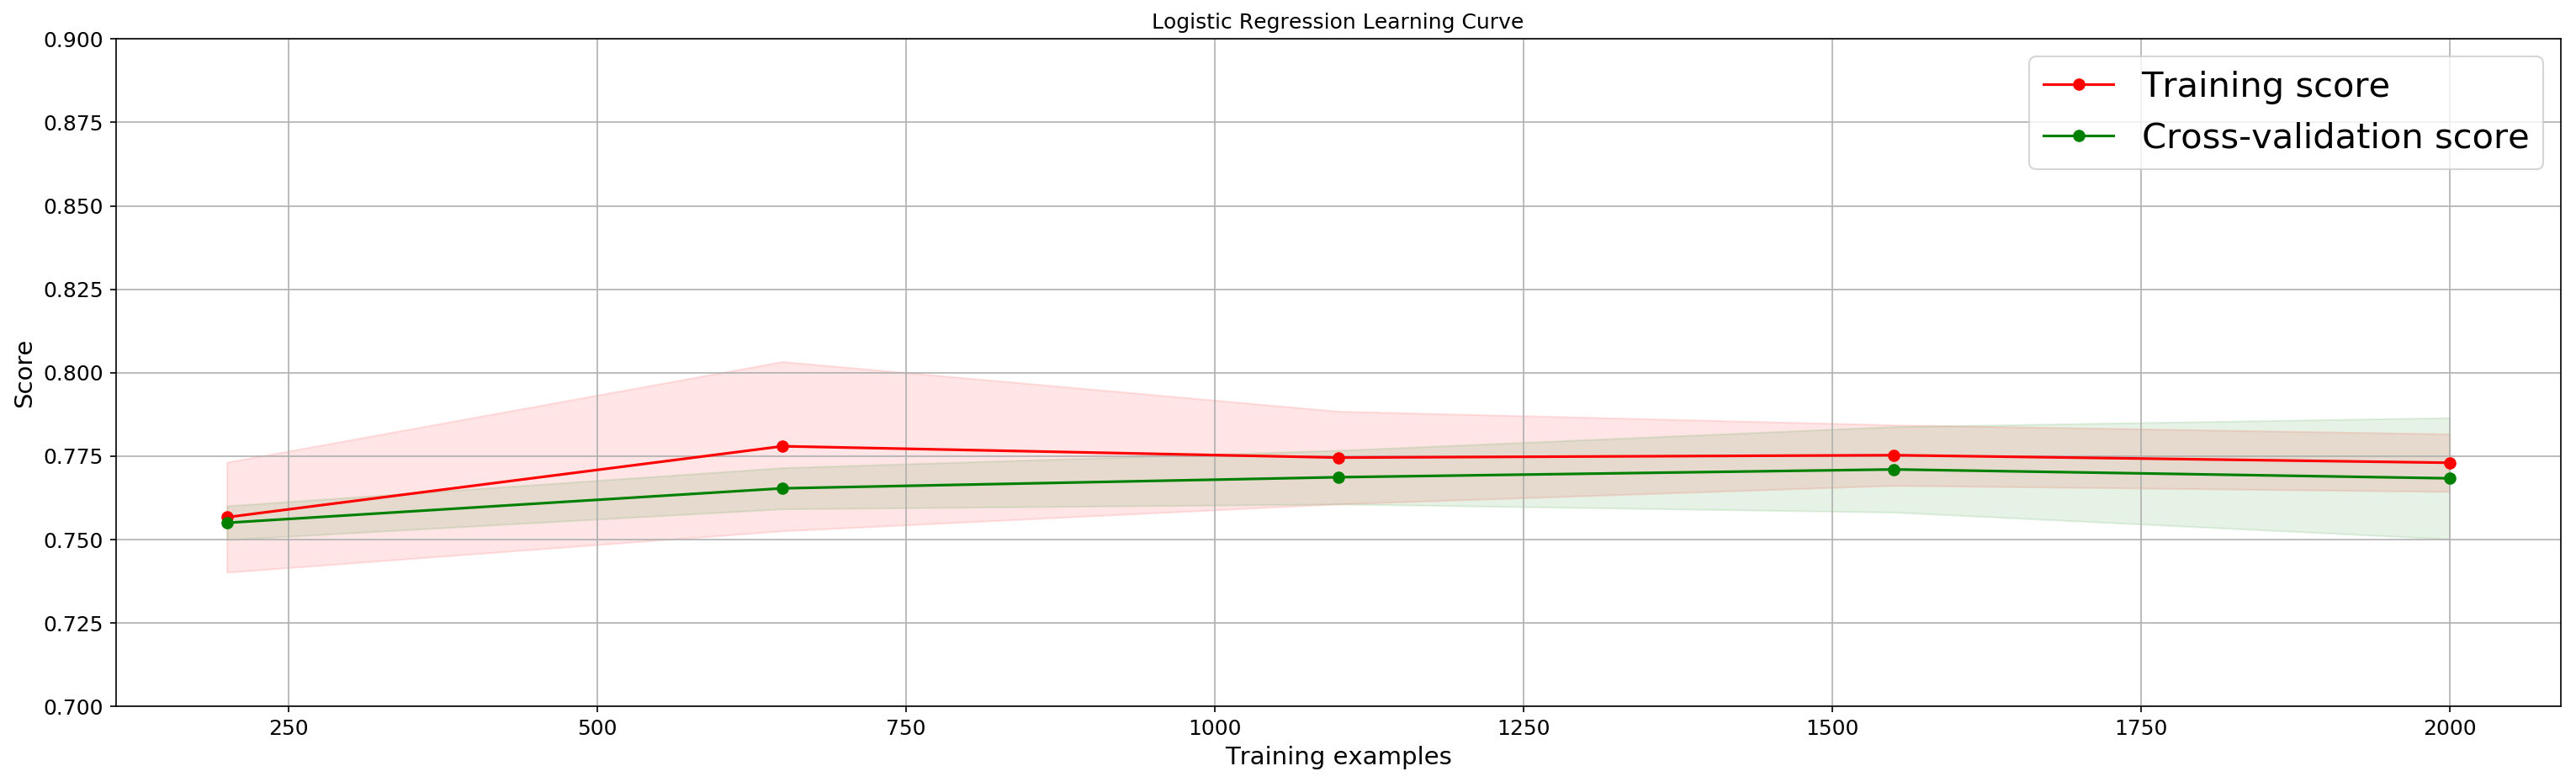

In [54]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_test, y_test, ylim=(0.7, 0.9), cv=3)   

In [55]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(logit_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.754, 0.794, 0.757])

In [56]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_logit_clf)

array([[2133,  123],
       [ 565,  179]])

In [57]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_logit_clf)

0.5927152317880795

In [58]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_logit_clf)

0.24059139784946237

# Sex vs Salary

In [59]:
# drop columns won't be useful in analysis and prediction
data_sex = data.drop(['fnlwgt', 'education-num', 'education', 
                      'race', 'native-country', 'workclass',
                      'age', 'occupation', 'capital-gain', 'capital-loss',
                      'hours-per-week'], axis=1)

In [60]:
data_sex.shape

(32560, 4)

In [61]:
data_sex.head()

,marital-status,relationship,sex,salary
0,Married-civ-spouse,Husband,Male,0
1,Divorced,Not-in-family,Male,0
2,Married-civ-spouse,Husband,Male,0
3,Married-civ-spouse,Wife,Female,0
4,Married-civ-spouse,Wife,Female,0


In [62]:
data_sex.tail()

,marital-status,relationship,sex,salary
32555,Married-civ-spouse,Wife,Female,0
32556,Married-civ-spouse,Husband,Male,1
32557,Widowed,Unmarried,Female,0
32558,Never-married,Own-child,Male,0
32559,Married-civ-spouse,Wife,Female,1


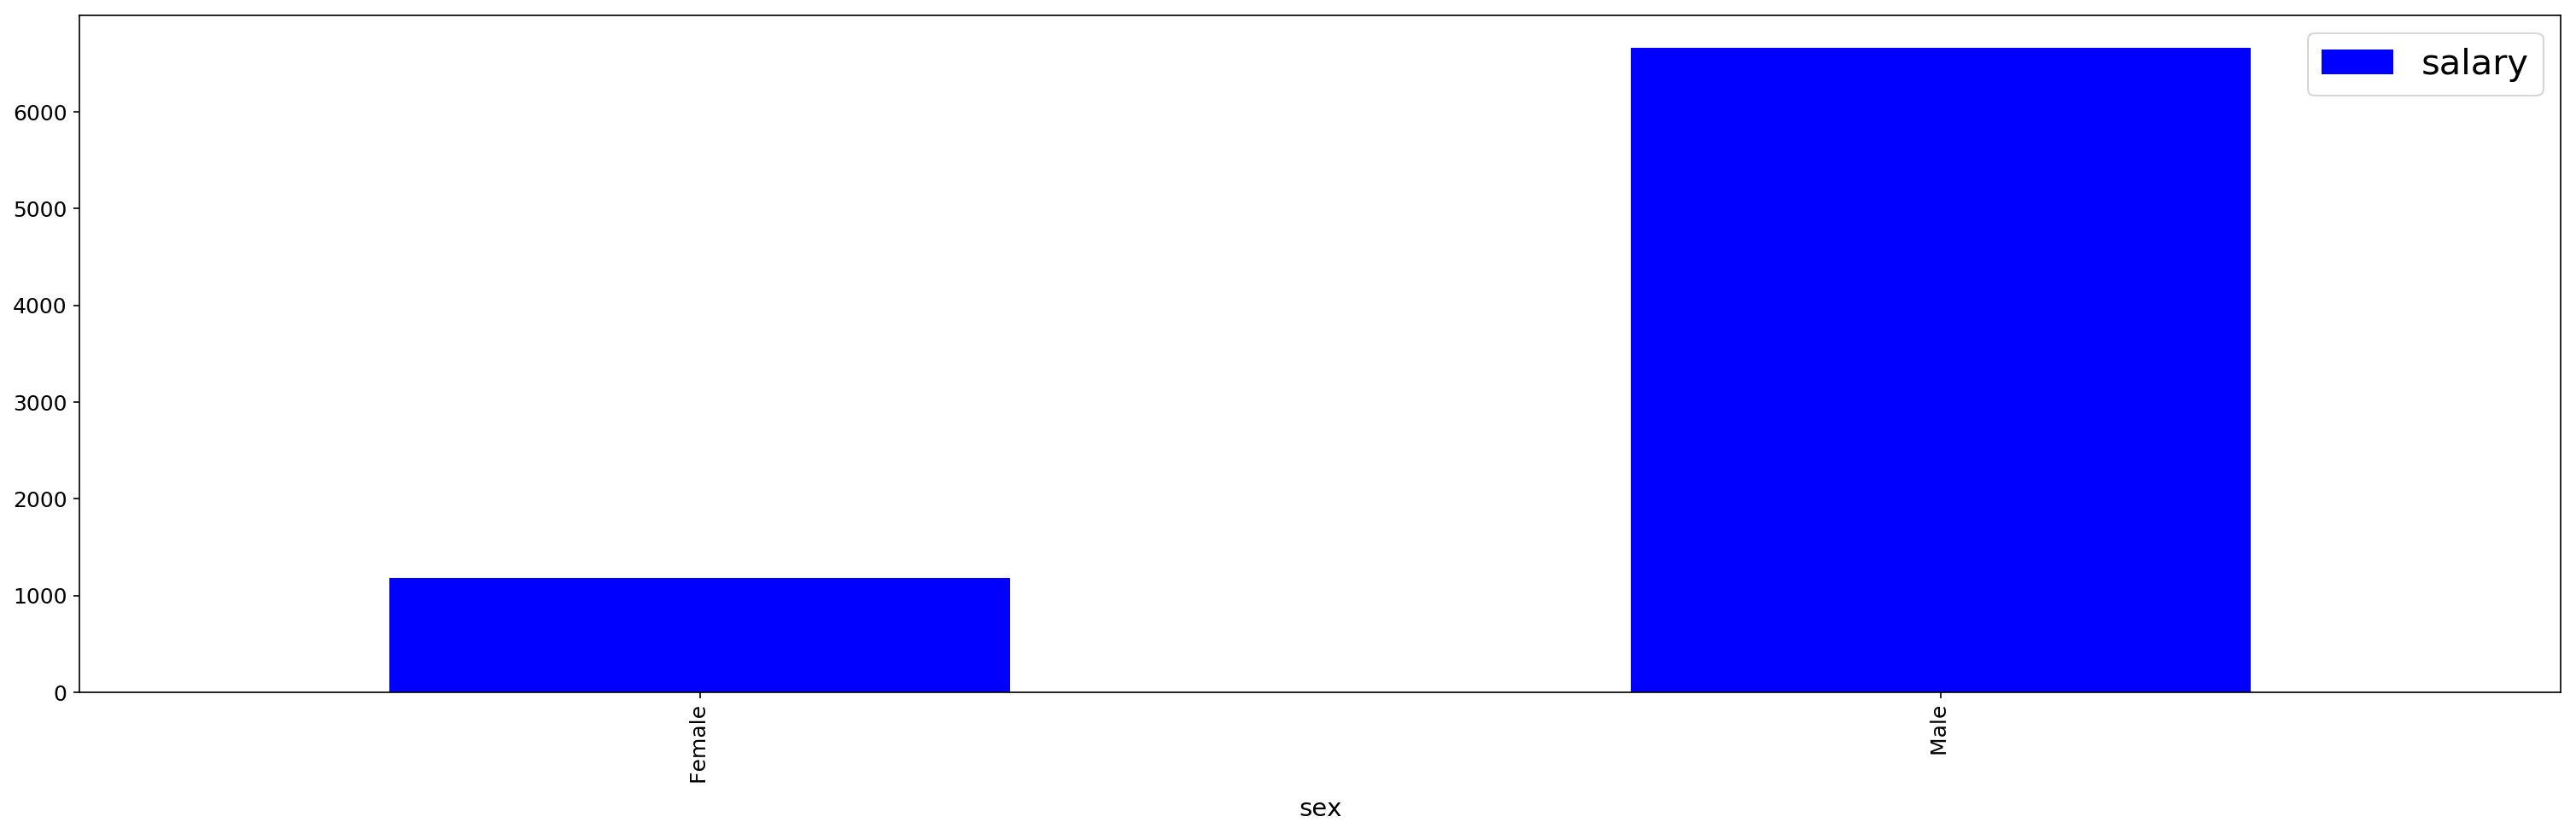

In [63]:
data_sex.groupby('sex').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [64]:
data_sex["sex"].value_counts()

 Male      21789
 Female    10771
Name: sex, dtype: int64

### apply 1-hot encoding to categorical features `Sex` 

In [65]:
data_sex.dtypes

marital-status    object
relationship      object
sex               object
salary             int64
dtype: object

In [66]:
data_sex.columns

Index(['marital-status', 'relationship', 'sex', 'salary'], dtype='object')

In [67]:
data_sex = pd.get_dummies(data_sex, columns=['sex'], prefix = ['sex'])
data_sex = pd.get_dummies(data_sex, columns=['marital-status'], prefix = ['marital-status'])
data_sex = pd.get_dummies(data_sex, columns=['relationship'], prefix = ['relationship'])

In [68]:
data_sex.dtypes

salary                                   int64
sex_ Female                              uint8
sex_ Male                                uint8
marital-status_ Divorced                 uint8
marital-status_ Married-AF-spouse        uint8
marital-status_ Married-civ-spouse       uint8
marital-status_ Married-spouse-absent    uint8
marital-status_ Never-married            uint8
marital-status_ Separated                uint8
marital-status_ Widowed                  uint8
relationship_ Husband                    uint8
relationship_ Not-in-family              uint8
relationship_ Other-relative             uint8
relationship_ Own-child                  uint8
relationship_ Unmarried                  uint8
relationship_ Wife                       uint8
dtype: object

In [69]:
data_sex.describe()

,salary,sex_ Female,sex_ Male,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
count,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,0.240817,0.330805,0.669195,0.136456,0.000706,0.459951,0.012838,0.328071,0.031480,0.030498,0.405190,0.255037,0.030129,0.155651,0.105835,0.048157
std,0.427586,0.470510,0.470510,0.343277,0.026569,0.498401,0.112576,0.469518,0.174615,0.171955,0.490936,0.435889,0.170945,0.362530,0.307632,0.214102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train data

In [70]:
data_sex.shape

(32560, 16)

In [71]:
X_train = data_sex.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_sex.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_sex.iloc[:7000]
y_train = y_train['salary']

y_test = data_sex.iloc[7000:]
y_test = y_test['salary']

## Create a Linear SVC and Learning Curve

In [72]:
svc_clf_1 = LinearSVC()
svc_clf_1.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [73]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="accuracy")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="recall")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="precision")

array([0.53543307, 0.51923077, 0.50847458])

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

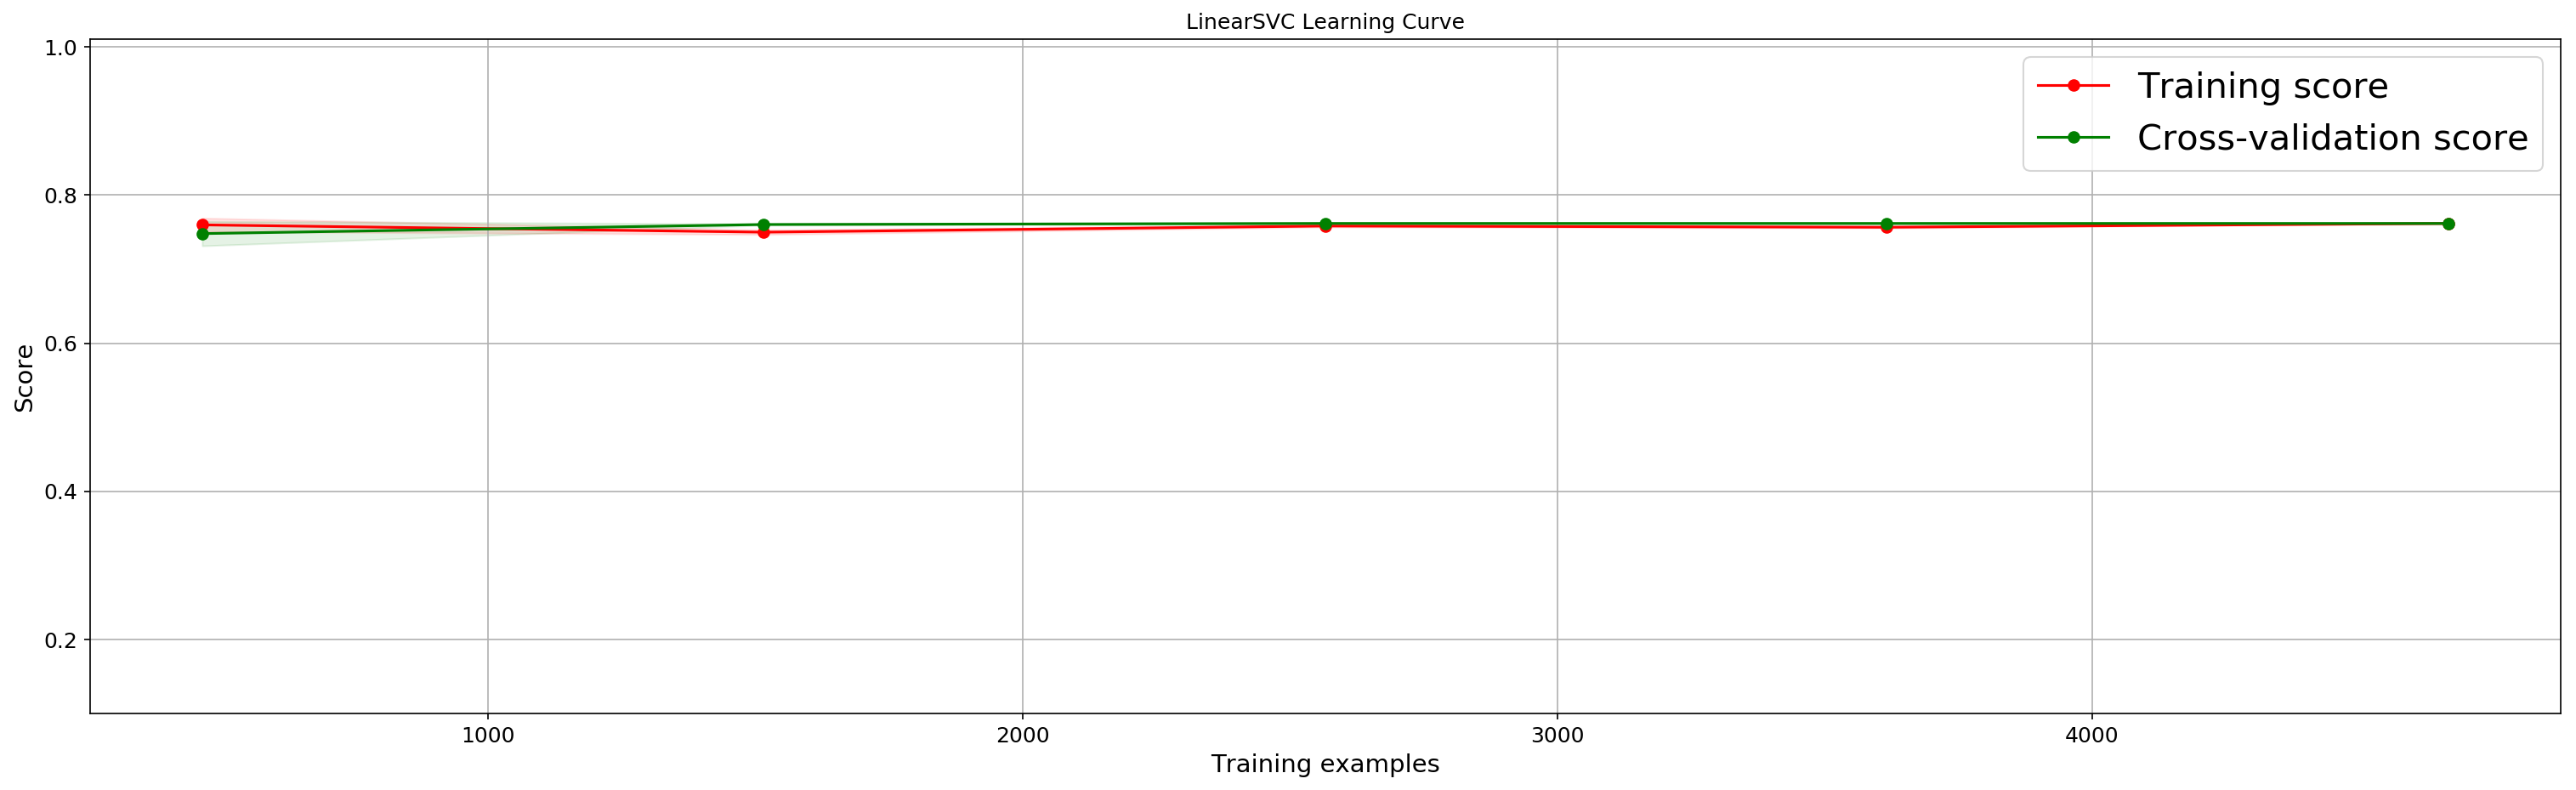

In [74]:
plot_learning_curve(svc_clf_1, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)   

## Random Forest

In [75]:
clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }


acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7552816901408451
